In [1]:
!pip install wandb
!pip install yfinance

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = DEBUG, 1 = INFO, 2 = WARNING, 3 = ERROR

In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
#Bloc 1 : Import des librairies

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import datetime
import yfinance as yf
import tensorflow as tf
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pickle

wandb.ensure_configured()  # S'assure que WandB est configuré correctement



In [5]:
#Bloc : config_wandb_lstm
def init_wandb_tracking(stock_symbol='BTC-USD'):
    wandb.init(
        project="lstm_crypto_all",
        name=f"lstm_{stock_symbol}_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}",
        tags=[
            stock_symbol,
            "short_term",
            "Deep Learning",
            "LSTM",
            "Optimized",
        ],
        settings=wandb.Settings(init_timeout=120),
        mode="online",
        config={
            "data": {
                "window_size": 90,
                "future_prediction_days": 30,
                "prediction_period_months": 6,
                "train_test_split": 0.7,
                "features": [
                  # Données de base OHLCV
                  'Open', 'High', 'Low', 'Close', 'Volume',

                  # Moyennes mobiles et leurs variations
                  'MA_5', 'MA_10', 'MA_20',
                  'MA_5_pct', 'MA_10_pct', 'MA_20_pct',

                  # RSI
                  'RSI',

                  # Bandes de Bollinger et leurs dérivés
                  'BB_upper', 'BB_lower', 'BB_width',

                  # MACD et ses composantes
                  'MACD', 'MACD_signal', 'MACD_hist',

                  # Stochastique
                  'Stoch_K', 'Stoch_D',

                  # Momentum et ROC
                  'Momentum', 'ROC',

                  # Indicateurs de volume
                  'Volume_MA', 'Volume_ROC', 'OBV'
              ],
                "stock_symbol": stock_symbol,
                "seed": 42,
                "scaling_min": 0,  # Ajouté pour la normalisation
                "scaling_max": 1,  # Ajouté pour la normalisation
                "dataset_info": {
                    "rows_count": None,
                    "start_date": None,
                    "end_date": None,
                    "data_loaded": False,
                    "available_columns": None,
                    "yfinance_status": None,
                    "sequence_info": {  # Ajouté pour le suivi des séquences
                        "total_sequences": None,
                        "training_sequences": None,
                        "test_sequences": None,
                        "sequence_shapes": None
                    }
                }
            },
            "technical_features": {
                "ma_periods": [10,20,30],
                "moving_averages": True,
                "rsi": True,
                "rsi_period": 21,
                "bollinger_bands": True,
                "bb_period": 20,
                "macd": False,
                "macd_params": {
                    "fast": 12,
                    "slow": 26,
                    "signal": 9
                },
                "stochastic": True,  # Changé à True
                "stochastic_period": 14,
                "momentum": True,    # Changé à True
                "volume_indicators": True  # Changé à True
            },

            "training": {
                "optimizer": "sgd",
                "batch_size": 128,
                "epochs": 100,
                "learning_rate": 0.00995,
                "dropout_rate": 0.23976834504739084,
                "early_stopping": True,
                "early_stopping_patience": 15,
                "validation_split": 0.3,
                "num_layers": 3,
                "units_per_layer": [512, 256],
                "recurrent_dropout": 0.3317792678391172,
                "momentum": 0.7773944766306407,
                "intermediate_dense_units": 128,  # Ajouté pour la couche dense intermédiaire
                "optimizer_params": {  # Ajouté pour les paramètres spécifiques des optimiseurs
                    "rmsprop": {
                        "rho": 0.9,
                        "epsilon": 1e-07
                    },
                    "adam": {
                        "epsilon": 1e-07
                    }
                }
            },
            "model": {
                "architecture": "lstm_double",
                "batch_normalization": False,
                "activation": "tanh",
                "input_shape": None,  # Sera mis à jour pendant l'exécution
                "output_shape": 1,    # Pour la prédiction univariée
                "save_format": "keras"  # Spécifie le format de sauvegarde
            },
            "metrics": {
                "loss": "huber",
                "val_loss": "mse",
                "mae": True,
                "rmse": True,
                "r2_score": True,
                "mape": True,
                "mase": True,
                "directional_accuracy": True,
                "training_history": {  # Ajouté pour suivre l'historique
                    "loss": None,
                    "val_loss": None,
                    "final_epoch": None,
                    "learning_rate": None
                }
            },
            "callbacks": {
                "early_stopping": {
                    "monitor": "val_loss",
                    "patience": 20,
                    "restore_best_weights": True
                },
                "reduce_lr_on_plateau": {
                    "monitor": "val_loss",
                    "factor": 0.46687704937797136,
                    "patience": 5,
                    "min_lr": 0.00001
                },
                "model_checkpoint": {
                    "save_best_only": True,
                    "monitor": "val_loss",
                    "filepath": None  # Sera défini avec wandb.run.id
                }
            },
            "artifacts": {  # Nouveau: pour suivre les artefacts générés
                "model_path": None,
                "scaler_path": "scaler.pkl",
                "best_model_path": "best_model.keras"
            }
        }
    )

In [6]:
# Bloc : data_import_and_preprocessing
# Résumé en 1 ligne : Télécharge les données financières à l'aide de yfinance, vérifie leur disponibilité et logue les informations du dataset dans WandB.

init_wandb_tracking()

# Définir le seed pour la reproductibilité
np.random.seed(wandb.config.data['seed'])

# Configuration de l'affichage des graphiques
# On garde simplement inline car c'est une configuration IPython
%matplotlib inline

# Récupérer les données
data = yf.download(wandb.config.data['stock_symbol'])

# Vérifier si des données ont été récupérées
if data.empty:
    print("Les données n'ont pas été récupérées.")
    wandb.config.data['dataset_info']['data_loaded'] = False
else:
    print("Données récupérées avec succès.")
    # Mettre à jour la configuration avec les informations réelles du dataset
    wandb.config.data['dataset_info'].update({
        "rows_count": len(data),
        "start_date": data.index.min().strftime('%Y-%m-%d'),
        "end_date": data.index.max().strftime('%Y-%m-%d'),
        "data_loaded": True
    })
    # Logger également ces informations comme métriques
    wandb.log({
        "dataset_info": {
            "rows_count": len(data),
            "start_date": data.index.min().strftime('%Y-%m-%d'),
            "end_date": data.index.max().strftime('%Y-%m-%d'),
            "data_loaded": True
        }
    })

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jerome0laval (jerome0laval-thermo-fisher-scientific). Use `wandb login --relogin` to force relogin


[*********************100%***********************]  1 of 1 completed

Données récupérées avec succès.


In [7]:
# Bloc : add_tech_indicators
#Ajoute des indicateurs techniques tels que moyennes mobiles, RSI, bandes de Bollinger, MACD, oscillateur stochastique et indicateurs de volume à un
#DataFrame financier en fonction d'une configuration donnée.

# Bloc : add_tech_indicators
def add_technical_indicators(df, config):
    """
    Ajoute les indicateurs techniques au DataFrame en fonction de la configuration
    """
    tech_features = config.technical_features

    if tech_features['moving_averages']:
        # Moyennes mobiles
        for period in tech_features['ma_periods']:
            df[f'MA_{period}'] = df['Close'].rolling(window=period).mean()
            df[f'MA_{period}_pct'] = df['Close'].pct_change(periods=period)

    if tech_features['rsi']:
        # RSI (Relative Strength Index)
        period = tech_features['rsi_period']
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

    if tech_features['bollinger_bands']:
        # Bandes de Bollinger
        period = tech_features['bb_period']
        bb_ma = df['Close'].rolling(window=period).mean()
        bb_std = df['Close'].rolling(window=period).std()
        df['BB_upper'] = bb_ma + (bb_std * 2)
        df['BB_lower'] = bb_ma - (bb_std * 2)
        df['BB_width'] = ((df['BB_upper'] - df['BB_lower']) / bb_ma).replace([np.inf, -np.inf], np.nan)

    if tech_features['macd']:
        # MACD
        fast = df['Close'].ewm(span=tech_features['macd_params']['fast']).mean()
        slow = df['Close'].ewm(span=tech_features['macd_params']['slow']).mean()
        df['MACD'] = fast - slow
        df['MACD_signal'] = df['MACD'].ewm(span=tech_features['macd_params']['signal']).mean()
        df['MACD_hist'] = df['MACD'] - df['MACD_signal']

    if tech_features['stochastic']:
        # Stochastic Oscillator
        period = tech_features['stochastic_period']
        low_min = df['Low'].rolling(window=period).min()
        high_max = df['High'].rolling(window=period).max()
        df['Stoch_K'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
        df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()

    if tech_features['momentum']:
        # Momentum et Rate of Change
        df['Momentum'] = df['Close'].pct_change(periods=10)
        df['ROC'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10) * 100)

    if tech_features['volume_indicators']:
        # Indicateurs de volume
        df['Volume_MA'] = df['Volume'].rolling(window=20).mean()
        df['Volume_ROC'] = df['Volume'].pct_change()
        df['OBV'] = (df['Close'].diff().map(lambda x: 1 if x > 0 else -1 if x < 0 else 0) * df['Volume']).cumsum()

    # Nettoyage final des valeurs infinies et NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    return df


In [8]:
# Bloc : data_preprocessing_and_features
# Résumé en 1 ligne : Prétraite les données financières en triant, nettoyant les valeurs manquantes, ajoutant des indicateurs techniques, et met à jour la configuration des features pour le modèle.


def preprocess_data(data, config):
    """
    Prétraite les données et ajoute les indicateurs techniques
    """
    # Prétraitement de base
    data = data.sort_index(ascending=True)

    # Si nous avons un MultiIndex, on l'aplatit
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in data.columns]

    data.reset_index(inplace=True)
    data.rename(columns={'Date': 'date'}, inplace=True)
    data['date'] = pd.to_datetime(data['date'])

    # Renommer les colonnes si nécessaire
    rename_dict = {
        'Adj Close_AF.PA': 'Adj Close',
        'Close_AF.PA': 'Close',
        'High_AF.PA': 'High',
        'Low_AF.PA': 'Low',
        'Open_AF.PA': 'Open',
        'Volume_AF.PA': 'Volume'
    }
    data.rename(columns=rename_dict, inplace=True)

    # Vérifier les données manquantes
    missing_values = data.isnull().sum()
    has_missing = missing_values.any()

    if has_missing:
        print("Des valeurs manquantes ont été détectées et seront remplies par propagation.")
        data.fillna(method="ffill", inplace=True)
        wandb.log({
            "preprocessing_info": {
                "missing_values_detected": True,
                "missing_values_count": missing_values.to_dict(),
                "missing_values_handling": "forward_fill"
            }
        })

    # Ajouter les indicateurs techniques
    try:
        data = add_technical_indicators(data, config)
        print("Indicateurs techniques ajoutés avec succès.")

        # Mettre à jour dataset_info dans la configuration
        config.data['dataset_info'].update({
            "available_columns": list(data.columns),
            "technical_indicators_added": True
        })

    except Exception as e:
        print(f"Erreur lors de l'ajout des indicateurs techniques: {str(e)}")
        config.data['dataset_info']['technical_indicators_added'] = False
        wandb.log({
            "preprocessing_error": {
                "step": "technical_indicators",
                "error_message": str(e)
            }
        })
        raise

    # Mettre à jour la liste des features
    base_features = ['Open', 'High', 'Low', 'Close', 'Volume']
    technical_features = [col for col in data.columns if col not in ['date'] + base_features]

    # Mettre à jour config.data['features'] pour inclure toutes les caractéristiques
    config.data['features'] = base_features + technical_features

    # Sélectionner les features pour le modèle
    data_features = data[config.data['features']]

    # Logger les informations de preprocessing
    wandb.log({
        "preprocessing_info": {
            "total_features": len(config.data['features']),
            "base_features": base_features,
            "technical_features": technical_features,
            "final_dataset_shape": {
                "rows": len(data_features),
                "columns": len(data_features.columns)
            }
        }
    })

    return data, data_features


In [9]:
# Bloc : data_normalization_and_sequence_preparation
# Résumé en 1 ligne : Normalise les données, crée des séquences temporelles pour l'entraînement et le test, sauvegarde le scaler utilisé, et logue les informations sur les données préparées dans WandB.

def prepare_sequences(data, config):
    """
    Prépare les séquences de données pour l'entraînement du modèle
    """
    # Vérifier les colonnes actuelles
    print("Colonnes disponibles avant prétraitement:", data.columns.tolist())

    # Mise à jour du statut dans WandB
    wandb.log({
        "preprocessing_status": {
            "initial_columns": data.columns.tolist()
        }
    })

    # Gestion du MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [f"{col[0]}" for col in data.columns]
        print("Colonnes après simplification:", data.columns.tolist())
        wandb.log({
            "preprocessing_status": {
                "multiindex_handled": True,
                "columns_after_simplification": data.columns.tolist()
            }
        })

    # Vérification du suffixe AC.PA
    elif any('AC.PA' in col for col in data.columns):
        rename_dict = {
            'Adj Close_AC.PA': 'Adj Close',
            'Close_AC.PA': 'Close',
            'High_AC.PA': 'High',
            'Low_AC.PA': 'Low',
            'Open_AC.PA': 'Open',
            'Volume_AC.PA': 'Volume'
        }
        data = data.rename(columns=rename_dict)
        wandb.log({
            "preprocessing_status": {
                "suffix_handled": True,
                "columns_renamed": rename_dict
            }
        })

    # Vérifier les colonnes requises
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        wandb.log({
            "preprocessing_error": {
                "missing_columns": missing_columns
            }
        })
        raise ValueError(f"Colonnes manquantes après renommage: {missing_columns}")
    else:
        print("Toutes les colonnes de base sont présentes.")

    # Prétraitement des données
    data, data_features = preprocess_data(data, config)
    print("Colonnes après prétraitement:", data_features.columns.tolist())

    # Paramètres de normalisation depuis la config
    scaling_params = {
        "min": config.data.get("scaling_min", 0),
        "max": config.data.get("scaling_max", 1)
    }

    # Normalisation des données
    scaler = MinMaxScaler(feature_range=(scaling_params["min"], scaling_params["max"]))
    scaled_data = scaler.fit_transform(data_features)

    wandb.log({
        "scaling_info": {
            "scaling_type": "MinMaxScaler",
            "feature_range": (scaling_params["min"], scaling_params["max"]),
            "features_scaled": list(data_features.columns)
        }
    })

    # Préparation des séquences
    window_size = config.data['window_size']
    target_column_name = "Close"
    try:
        target_column = list(data_features.columns).index(target_column_name)
    except ValueError:
        wandb.log({
            "sequence_preparation_error": {
                "error_type": "MissingTargetColumn",
                "target_column": target_column_name,
                "available_columns": list(data_features.columns)
            }
        })
        raise ValueError(f"La colonne '{target_column_name}' n'est pas présente dans les features")

    # Création des séquences
    X, Y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size:i])
        Y.append(scaled_data[i, target_column])

    X, Y = np.array(X), np.array(Y)


    # Validation des séquences
    if len(X) == 0 or len(Y) == 0:
        wandb.log({
            "sequence_preparation_error": {
                "error_type": "EmptySequences",
                "X_length": len(X),
                "Y_length": len(Y)
            }
        })
        raise ValueError("Les séquences d'entraînement sont vides. Vérifiez les paramètres de prétraitement.")

    print(f"Forme de X: {X.shape}, Forme de Y: {Y.shape}")

    # Division train/test
    training_size = int(len(X) * config.data['train_test_split'])
    X_train, X_test = X[:training_size], X[training_size:]
    Y_train, Y_test = Y[:training_size], Y[training_size:]

    print(f"Forme de X_train: {X_train.shape}, X_test: {X_test.shape}")
    print(f"Forme de Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")

    # Sauvegarde du scaler
    scaler_filename = "scaler.pkl"
    with open(scaler_filename, "wb") as f:
        pickle.dump(scaler, f)

    # Création et log de l'artefact scaler
    run_id = wandb.run.id if wandb.run else "unknown"
    scaler_artifact = wandb.Artifact(
        name=f"data_scaler_{run_id}",  # Nom unique pour chaque run
        type="scaler",
        description="MinMaxScaler utilisé pour la normalisation des données"
    )
    scaler_artifact.add_file(scaler_filename)
    wandb.log_artifact(scaler_artifact)

    # Log des informations finales
    wandb.log({
        "sequence_preparation": {
            "window_size": window_size,
            "total_sequences": len(X),
            "training_sequences": len(X_train),
            "test_sequences": len(X_test),
            "sequence_shapes": {
                "X_total": X.shape,
                "Y_total": Y.shape,
                "X_train": X_train.shape,
                "X_test": X_test.shape,
                "Y_train": Y_train.shape,
                "Y_test": Y_test.shape
            },
            "target_info": {
                "column_name": target_column_name,
                "column_index": target_column
            },
            "train_test_split": config.data['train_test_split']
        }
    })

    return X_train, X_test, Y_train, Y_test, scaler

X_train, X_test, Y_train, Y_test, scaler = prepare_sequences(data, wandb.config)

Colonnes disponibles avant prétraitement: [('Adj Close', 'BTC-USD'), ('Close', 'BTC-USD'), ('High', 'BTC-USD'), ('Low', 'BTC-USD'), ('Open', 'BTC-USD'), ('Volume', 'BTC-USD')]
Colonnes après simplification: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
Toutes les colonnes de base sont présentes.
Indicateurs techniques ajoutés avec succès.
Colonnes après prétraitement: ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'MA_10', 'MA_10_pct', 'MA_20', 'MA_20_pct', 'MA_30', 'MA_30_pct', 'RSI', 'BB_upper', 'BB_lower', 'BB_width', 'Stoch_K', 'Stoch_D', 'Momentum', 'ROC', 'Volume_MA', 'Volume_ROC', 'OBV']
Forme de X: (3633, 90, 23), Forme de Y: (3633,)
Forme de X_train: (2543, 90, 23), X_test: (1090, 90, 23)
Forme de Y_train: (2543,), Y_test: (1090,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - loss: 0.0094 - val_loss: 0.0068 - learning_rate: 0.0099
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - loss: 0.0044 - val_loss: 0.0025 - learning_rate: 0.0099
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - loss: 0.0039 - val_loss: 0.0026 - learning_rate: 0.0099
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - loss: 0.0036 - val_loss: 0.0023 - learning_rate: 0.0099
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 0.0035 - val_loss: 0.0021 - learning_rate: 0.0099
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - loss: 0.0032 - val_loss: 0.0023 - learning_rate: 0.0099
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 379ms/step - loss: 0.0036 - val_loss: 0.0020 - learning_rate: 0.0099
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - loss: 0.0033 - val_loss: 0.0017 - learning_rate: 0.0099
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - loss: 0.0029 - val_loss: 0.0019 - learning_rate: 0.

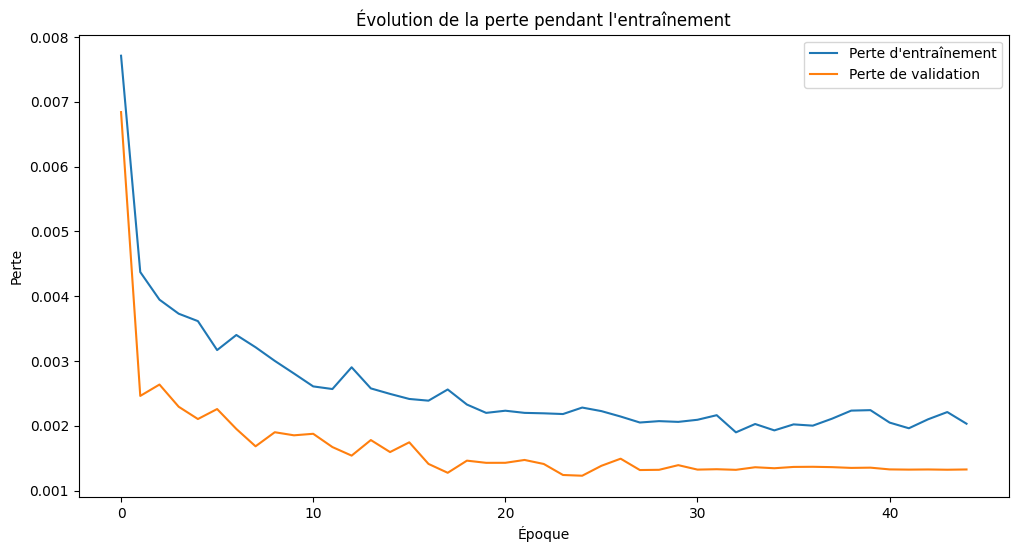

In [10]:
# Bloc : lstm_model_training
# Résumé en 1 ligne : Définit, entraîne, et évalue un modèle LSTM optimisé avec callbacks, visualise les pertes d'entraînement/validation et logue les métriques clés dans WandB.

# Import des couches supplémentaires
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Construction du modèle LSTM
model = Sequential()

# Mise à jour de la configuration avec la forme d'entrée
wandb.config.model['input_shape'] = (X_train.shape[1], X_train.shape[2])

# Configuration de base
units_per_layer = wandb.config.training['units_per_layer']
dropout_rate = wandb.config.training['dropout_rate']
recurrent_dropout = wandb.config.training['recurrent_dropout']

# Première couche LSTM avec BatchNormalization
model.add(LSTM(
    units=units_per_layer[0],
    return_sequences=True,
    dropout=dropout_rate,
    recurrent_dropout=recurrent_dropout,
    input_shape=wandb.config.model['input_shape']
))
if wandb.config.model['batch_normalization']:
    model.add(BatchNormalization())

# Deuxième couche LSTM
model.add(LSTM(
    units=units_per_layer[1],
    return_sequences=False,
    dropout=dropout_rate,
    recurrent_dropout=recurrent_dropout
))
if wandb.config.model['batch_normalization']:
    model.add(BatchNormalization())

# Couche Dense intermédiaire avec activation ReLU
model.add(Dense(
    units=wandb.config.training['intermediate_dense_units'],
    activation=wandb.config.model['activation']
))
model.add(Dropout(dropout_rate))

# Couche de sortie
model.add(Dense(units=wandb.config.model['output_shape']))

# Configuration de l'optimiseur
learning_rate = wandb.config.training['learning_rate']
momentum = wandb.config.training['momentum']

# Map des optimiseurs avec les paramètres de la config
optimizers = {
    'rmsprop': tf.keras.optimizers.RMSprop(
        learning_rate=learning_rate,
        rho=wandb.config.training['optimizer_params']['rmsprop']['rho'],
        momentum=momentum,
        epsilon=wandb.config.training['optimizer_params']['rmsprop']['epsilon']
    ),
    'adam': tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        epsilon=wandb.config.training['optimizer_params']['adam']['epsilon']
    ),
    'sgd': tf.keras.optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    )
}

# Sélection de l'optimiseur
optimizer = optimizers[wandb.config.training['optimizer']]

# Compilation du modèle
model.compile(
    optimizer=optimizer,
    loss=wandb.config.metrics['loss']
)

# Configuration du nom du fichier pour le checkpoint
wandb.config.callbacks['model_checkpoint']['filepath'] = wandb.config.artifacts['best_model_path']

# Callbacks améliorés
callbacks = [
    # Early Stopping
    EarlyStopping(
        monitor=wandb.config.callbacks['early_stopping']['monitor'],
        patience=wandb.config.callbacks['early_stopping']['patience'],
        restore_best_weights=wandb.config.callbacks['early_stopping']['restore_best_weights']
    ),

    # Reduce LR On Plateau
    ReduceLROnPlateau(
        monitor=wandb.config.callbacks['reduce_lr_on_plateau']['monitor'],
        factor=wandb.config.callbacks['reduce_lr_on_plateau']['factor'],
        patience=wandb.config.callbacks['reduce_lr_on_plateau']['patience'],
        min_lr=wandb.config.callbacks['reduce_lr_on_plateau']['min_lr']
    ),

    # Model Checkpoint
    ModelCheckpoint(
        wandb.config.callbacks['model_checkpoint']['filepath'],
        monitor=wandb.config.callbacks['model_checkpoint']['monitor'],
        save_best_only=wandb.config.callbacks['model_checkpoint']['save_best_only']
    )
]

# Entraînement du modèle
history = model.fit(
    X_train, Y_train,
    epochs=wandb.config.training['epochs'],
    batch_size=wandb.config.training['batch_size'],
    validation_data=(X_test, Y_test),
    callbacks=callbacks,
    verbose=1
)

# Évaluation et métriques
test_loss = model.evaluate(X_test, Y_test, verbose=0)
predicted_test = model.predict(X_test, verbose=0)

# Calcul des métriques
metrics = {
    "test_loss": test_loss,
    "train_loss": history.history['loss'][-1],
    "val_loss": history.history['val_loss'][-1],
    "mae": mean_absolute_error(Y_test, predicted_test),
    "rmse": np.sqrt(mean_squared_error(Y_test, predicted_test)),
    "r2_score": r2_score(Y_test, predicted_test),
    "mape": mean_absolute_percentage_error(Y_test, predicted_test) * 100,
}

# Fonction pour le calcul de la précision directionnelle
def calculate_directional_accuracy(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)

    if len(y_true) != len(y_pred):
        raise ValueError(f"Les dimensions ne correspondent pas: y_true ({len(y_true)}) vs y_pred ({len(y_pred)})")

    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    return np.mean((true_diff * pred_diff) > 0) * 100

# Calcul de la précision directionnelle
metrics["directional_accuracy"] = calculate_directional_accuracy(
    Y_test,
    predicted_test.reshape(-1)
)

# Mise à jour de l'historique d'entraînement dans la config
wandb.config.metrics['training_history'].update({
    "loss": history.history['loss'],
    "val_loss": history.history['val_loss'],
    "final_epoch": len(history.history['loss']),
    "learning_rate": optimizer.learning_rate.numpy()
})

# Log des métriques dans W&B
wandb.log(metrics)

# Visualisations
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

# Log des visualisations
wandb.log({
    "training_history_plot": wandb.Image(plt)
})

# Sauvegarde du modèle
wandb.config.artifacts['model_path'] = f"model_{wandb.run.id}.{wandb.config.model['save_format']}"
model.save(wandb.config.artifacts['model_path'])
wandb.save(wandb.config.artifacts['model_path'])

# Log final du statut d'entraînement
wandb.log({
    "training_completed": True,
    "model_saved": True,
    "final_model_path": wandb.config.artifacts['model_path'],
    "best_model_path": wandb.config.artifacts['best_model_path']
})

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
MAE: 3576.0820
MSE: 27626285.3535
RMSE: 5256.0713
R2_SCORE: 0.9336
MAPE: 8.5401
MASE: 4.4459


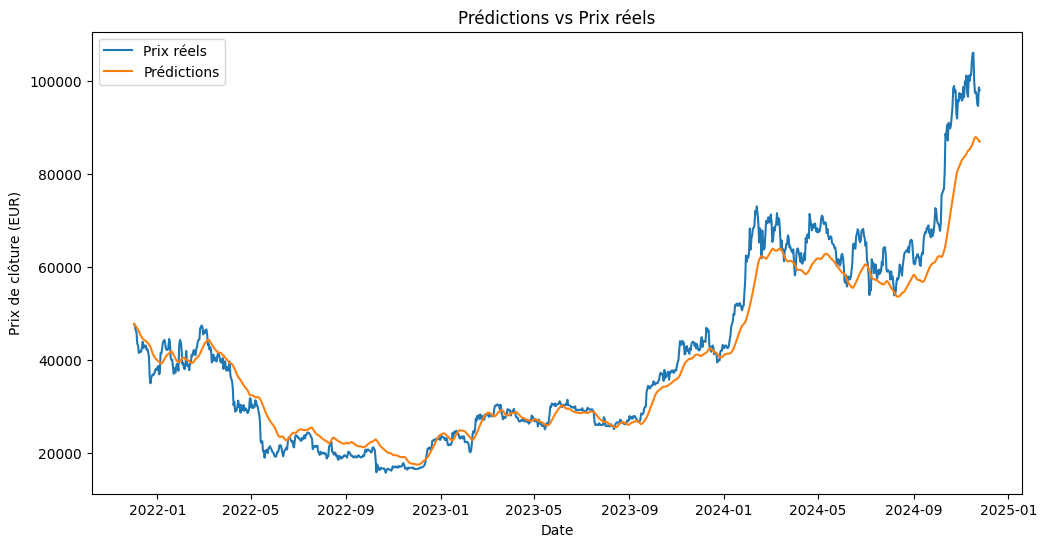

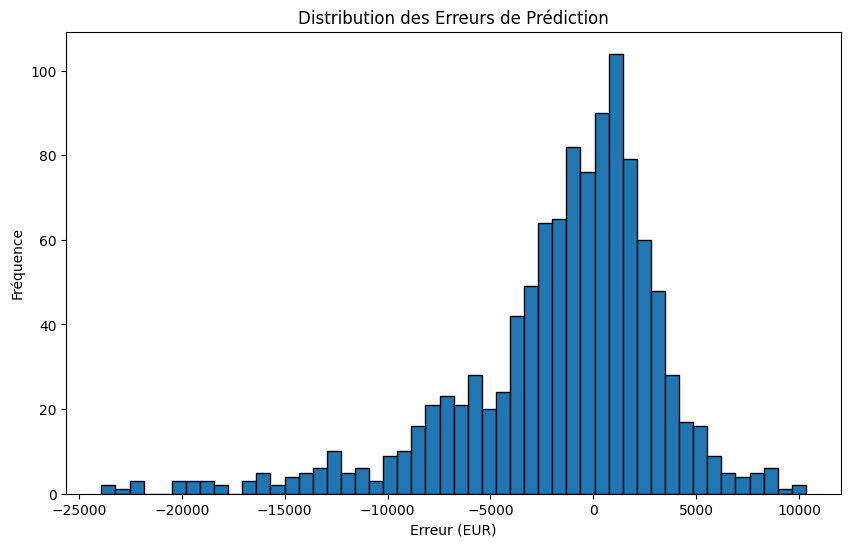

In [11]:
def evaluate_model(model, X_test, Y_test, scaler, data, X_train, config):
    # Calcul du training_size à partir de X_train
    training_size = len(X_train)
    window_size = config.data['window_size']

    # Récupération des features et de l'index de la colonne cible
    features = config.data['features']
    target_column = features.index('Close') if 'Close' in features else None

    if target_column is None:
        wandb.log({"evaluation_error": "Target column 'Close' not found in features"})
        raise ValueError("La colonne cible 'Close' n'est pas dans les features configurées.")

    # Prédictions sur l'ensemble de test
    predictions = model.predict(X_test).reshape(-1, 1)

    # Préparation pour l'inverse transform
    pred_full = np.zeros((predictions.shape[0], len(features)))
    pred_full[:, target_column] = predictions.flatten()

    # Inverse transform
    predicted_prices = scaler.inverse_transform(pred_full)[:, target_column]
    real_prices = scaler.inverse_transform(
        np.hstack([
            np.zeros((Y_test.shape[0], target_column)),
            Y_test.reshape(-1, 1),
            np.zeros((Y_test.shape[0], len(features) - target_column - 1))
        ])
    )[:, target_column]

    # Calcul des métriques
    evaluation_metrics = {
        "mae": mean_absolute_error(real_prices, predicted_prices),
        "mse": mean_squared_error(real_prices, predicted_prices),
        "rmse": np.sqrt(mean_squared_error(real_prices, predicted_prices)),
        "r2_score": r2_score(real_prices, predicted_prices),
        "mape": mean_absolute_percentage_error(real_prices, predicted_prices) * 100
    }

    # Calcul du MASE
    naive_forecast = real_prices[:-1]
    mae_naive = mean_absolute_error(real_prices[1:], naive_forecast)
    evaluation_metrics["mase"] = evaluation_metrics["mae"] / mae_naive if mae_naive != 0 else None

    # Affichage des métriques
    for metric, value in evaluation_metrics.items():
        if value is not None:
            print(f"{metric.upper()}: {value:.4f}")

    # Visualisations
    # 1. Prédictions vs Prix réels
    plt.figure(figsize=(12, 6))
    dates = data.index[training_size + window_size:training_size + window_size + len(predicted_prices)]
    plt.plot(dates, real_prices, label='Prix réels')
    plt.plot(dates, predicted_prices, label='Prédictions')
    plt.title('Prédictions vs Prix réels')
    plt.xlabel('Date')
    plt.ylabel('Prix de clôture (EUR)')
    plt.legend()

    # Log de la première visualisation
    wandb.log({
        "predictions_vs_actual": wandb.Image(plt),
        "evaluation_metrics": evaluation_metrics,
        "prediction_info": {
            "window_size": config.data['window_size'],
            "target_column": "Close",
            "test_set_size": len(X_test),
            "prediction_start_date": dates[0].strftime('%Y-%m-%d'),
            "prediction_end_date": dates[-1].strftime('%Y-%m-%d')
        }
    })
    plt.show()
    plt.close()

    # 2. Distribution des erreurs
    errors = predicted_prices - real_prices
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, edgecolor='black')
    plt.title('Distribution des Erreurs de Prédiction')
    plt.xlabel('Erreur (EUR)')
    plt.ylabel('Fréquence')

    # Log de la distribution des erreurs et statistiques
    wandb.log({
        "error_distribution": wandb.Image(plt),
        "error_statistics": {
            "mean_error": np.mean(errors),
            "std_error": np.std(errors),
            "max_error": np.max(np.abs(errors)),
            "min_error": np.min(errors)
        }
    })
    plt.show()
    plt.close()

    return evaluation_metrics, predicted_prices, real_prices

# Appel de la fonction d'évaluation
metrics, predicted_prices, real_prices = evaluate_model(
    model=model,
    X_test=X_test,
    Y_test=Y_test,
    scaler=scaler,
    data=data,
    X_train=X_train,
    config=wandb.config
)

In [12]:
# Bloc : last_six_months_filter
# Cette fonction doit être exécutée avant visualize_all_predictions
def prepare_filtered_data(data, real_prices, predicted_prices, config):
    """
    Prépare les données filtrées sur les derniers mois
    """
    # Calculer les dates de début et de fin
    end_date = datetime.date.today()
    months = config.data.get("prediction_period_months", 6)
    start_date = end_date - pd.DateOffset(months=months)

    # Formatage des dates
    test_start_date = start_date.strftime('%Y-%m-%d')
    test_end_date = end_date.strftime('%Y-%m-%d')

    # Filtrer les données
    filtered_data = data[test_start_date:test_end_date]

    if filtered_data.empty:
        print("Aucune donnée disponible pour la période spécifiée.")
        return None, None, None

    # Récupérer les indices correspondants
    filtered_dates = filtered_data.index
    filtered_real_prices = real_prices[-len(filtered_dates):]
    filtered_predictions = predicted_prices[-len(filtered_dates):]

    return filtered_dates, filtered_real_prices, filtered_predictions

# Préparation des données filtrées
filtered_dates, filtered_real_prices, filtered_predictions = prepare_filtered_data(
    data=data,
    real_prices=real_prices,
    predicted_prices=predicted_prices,
    config=wandb.config
)

# Maintenant on peut appeler visualize_all_predictions
viz_data = visualize_all_predictions(
    data=data,
    filtered_dates=filtered_dates,
    filtered_real_prices=filtered_real_prices,
    filtered_predictions=filtered_predictions,
    future_dates=future_dates,
    future_prices=future_prices,
    config=wandb.config
)

NameError: name 'visualize_all_predictions' is not defined

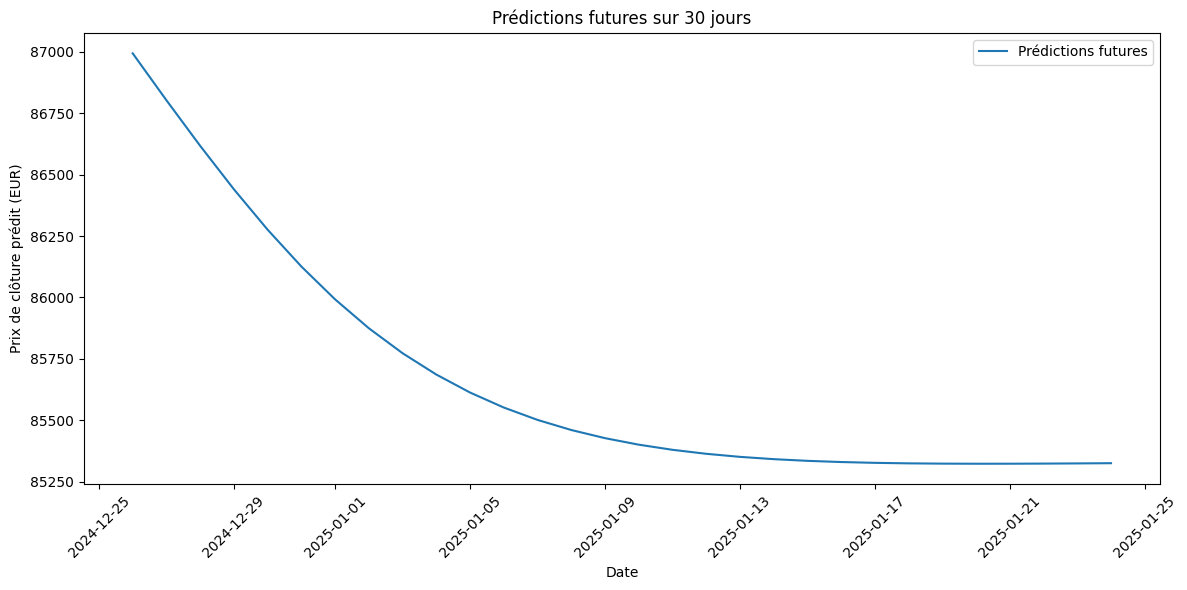


Prédictions détaillées :
Date: 2024-12-26, Prix prédit: 86993.44 EUR
Date: 2024-12-27, Prix prédit: 86802.57 EUR
Date: 2024-12-28, Prix prédit: 86617.02 EUR
Date: 2024-12-29, Prix prédit: 86440.21 EUR
Date: 2024-12-30, Prix prédit: 86275.70 EUR
Date: 2024-12-31, Prix prédit: 86125.93 EUR
Date: 2025-01-01, Prix prédit: 85992.17 EUR
Date: 2025-01-02, Prix prédit: 85874.69 EUR
Date: 2025-01-03, Prix prédit: 85773.04 EUR
Date: 2025-01-04, Prix prédit: 85686.26 EUR
Date: 2025-01-05, Prix prédit: 85613.05 EUR
Date: 2025-01-06, Prix prédit: 85552.01 EUR
Date: 2025-01-07, Prix prédit: 85501.64 EUR
Date: 2025-01-08, Prix prédit: 85460.55 EUR
Date: 2025-01-09, Prix prédit: 85427.36 EUR
Date: 2025-01-10, Prix prédit: 85400.86 EUR
Date: 2025-01-11, Prix prédit: 85379.96 EUR
Date: 2025-01-12, Prix prédit: 85363.71 EUR
Date: 2025-01-13, Prix prédit: 85351.26 EUR
Date: 2025-01-14, Prix prédit: 85341.91 EUR
Date: 2025-01-15, Prix prédit: 85335.05 EUR
Date: 2025-01-16, Prix prédit: 85330.18 EUR
Date: 

In [13]:
# Bloc : future_predictions_30_days
# Résumé en 1 ligne : Génère les prédictions des 30 prochains jours, visualise les prix prédits, calcule les statistiques de variation, et logue les résultats détaillés et graphiques dans WandB.

def generate_future_predictions(model, X_test, X_train, data, scaler, config):
    """
    Génère et analyse les prédictions futures
    """
    # Paramètres de base
    future_days = config.data.get("future_prediction_days", 30)
    window_size = config.data['window_size']
    features = config.data['features']
    target_column_index = features.index("Close") if "Close" in features else None

    # Vérification de la colonne cible
    if target_column_index is None:
        wandb.log({"future_prediction_error": "Missing Close column"})
        raise ValueError("La colonne 'Close' n'existe pas dans les features configurées.")

    # Génération des prédictions
    future_predictions = []
    last_sequence = X_test[-1]

    for _ in range(future_days):
        # Prédiction
        next_pred = model.predict(last_sequence.reshape(1, window_size, X_train.shape[2]), verbose=0)
        future_predictions.append(next_pred[0, 0])

        # Mise à jour de la séquence
        next_time_step = last_sequence[-1].copy()
        next_time_step[target_column_index] = next_pred[0, 0]
        last_sequence = np.append(last_sequence[1:], [next_time_step], axis=0)

    # Dénormalisation des prédictions
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    pred_full = np.zeros((future_predictions.shape[0], len(features)))
    pred_full[:, target_column_index] = future_predictions.flatten()
    future_prices = scaler.inverse_transform(pred_full)[:, target_column_index]

    # Génération des dates futures
    last_date = pd.to_datetime(data.index[-1])
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=future_days,
        freq='D'
    )

    # Visualisation
    plt.figure(figsize=(12, 6))
    plt.plot(future_dates, future_prices, label='Prédictions futures')
    plt.title(f'Prédictions futures sur {future_days} jours')
    plt.xlabel('Date')
    plt.ylabel('Prix de clôture prédit (EUR)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Log du graphique
    wandb.log({
        "future_predictions": {
            "plot": wandb.Image(plt),
            "forecast_period": future_days,
            "start_date": future_dates[0].strftime('%Y-%m-%d'),
            "end_date": future_dates[-1].strftime('%Y-%m-%d')
        }
    })
    plt.show()

    # Affichage détaillé des prédictions
    print("\nPrédictions détaillées :")
    for i, date in enumerate(future_dates):
        print(f"Date: {date.strftime('%Y-%m-%d')}, Prix prédit: {future_prices[i]:.2f} EUR")

    # Calcul des statistiques
    stats = {
        "initial_price": future_prices[0],
        "final_price": future_prices[-1],
        "absolute_change": future_prices[-1] - future_prices[0],
        "percentage_change": ((future_prices[-1] - future_prices[0]) / future_prices[0]) * 100,
        "min_price": np.min(future_prices),
        "max_price": np.max(future_prices),
        "mean_price": np.mean(future_prices),
        "std_price": np.std(future_prices)
    }

    # Affichage des statistiques
    print("\nStatistiques des prédictions:")
    print(f"Prix initial: {stats['initial_price']:.2f} EUR")
    print(f"Prix final: {stats['final_price']:.2f} EUR")
    print(f"Variation absolue: {stats['absolute_change']:.2f} EUR")
    print(f"Variation en pourcentage: {stats['percentage_change']:.2f}%")

    # Log complet dans WandB
    wandb.log({
        "future_predictions_details": {
            "daily_predictions": {
                date.strftime('%Y-%m-%d'): {
                    "price": price,
                    "day_number": i + 1
                }
                for i, (date, price) in enumerate(zip(future_dates, future_prices))
            },
            "statistics": stats,
            "model_config": {
                "window_size": window_size,
                "features_used": features
            }
        }
    })

    return future_dates, future_prices, stats

# Appel de la fonction
future_dates, future_prices, prediction_stats = generate_future_predictions(
    model=model,
    X_test=X_test,
    X_train=X_train,
    data=data,
    scaler=scaler,
    config=wandb.config
)

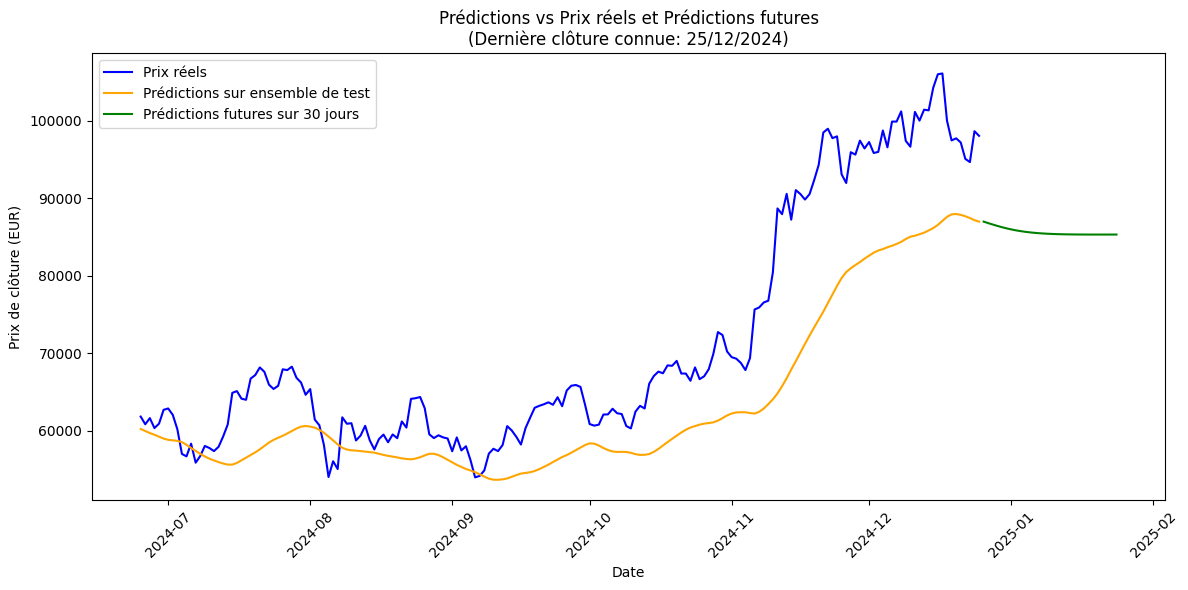

In [14]:
# Bloc : predictions_visualization
# Résumé en 1 ligne : Visualise les prix réels, les prédictions sur l'ensemble de test, et les prédictions futures avec une séparation claire entre les périodes.

def visualize_all_predictions(data, filtered_dates, filtered_real_prices, filtered_predictions,
                            future_dates, future_prices, config):
    """
    Crée une visualisation complète combinant données historiques et prédictions futures
    """
    # Configuration
    future_days = config.data.get("future_prediction_days", 30)

    # Détermination des dates
    if 'date' in data.columns:
        derniere_date_connue = data['date'].iloc[-1]
        future_start_date = derniere_date_connue + datetime.timedelta(days=1)
    else:
        derniere_date_connue = data.index[-1]
        future_start_date = derniere_date_connue + datetime.timedelta(days=1)

    derniere_date_str = derniere_date_connue.strftime('%d/%m/%Y')

    # Vérification de l'intégrité des données
    if not (len(filtered_dates) == len(filtered_real_prices) == len(filtered_predictions)):
        print("Erreur : Incohérence dans les longueurs des données historiques")
        return

    if not (len(future_dates) == len(future_prices)):
        print("Erreur : Incohérence dans les longueurs des données futures")
        return

    # Création de la visualisation
    plt.figure(figsize=(12, 6))

    # Prix réels et prédictions historiques
    plt.plot(filtered_dates, filtered_real_prices,
             label='Prix réels', color='blue')
    plt.plot(filtered_dates, filtered_predictions,
             label='Prédictions sur ensemble de test', color='orange')

    # Prédictions futures
    plt.plot(future_dates, future_prices,
             label=f'Prédictions futures sur {future_days} jours', color='green')

    # Configuration du graphique
    plt.title(f'Prédictions vs Prix réels et Prédictions futures\n(Dernière clôture connue: {derniere_date_str})')
    plt.xlabel('Date')
    plt.ylabel('Prix de clôture (EUR)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Log dans WandB
    visualization_data = {
        "combined_predictions_plot": wandb.Image(plt),
        "visualization_info": {
            "historical_period": {
                "start_date": filtered_dates[0].strftime('%Y-%m-%d'),
                "end_date": filtered_dates[-1].strftime('%Y-%m-%d'),
                "number_of_days": len(filtered_dates)
            },
            "future_period": {
                "start_date": future_start_date.strftime('%Y-%m-%d'),
                "end_date": future_dates[-1].strftime('%Y-%m-%d'),
                "prediction_days": future_days
            },
            "price_ranges": {
                "historical_min": min(filtered_real_prices),
                "historical_max": max(filtered_real_prices),
                "future_min": min(future_prices),
                "future_max": max(future_prices)
            },
            "last_known_price": filtered_real_prices[-1],
            "first_predicted_price": future_prices[0]
        }
    }

    wandb.log(visualization_data)

    plt.show()

    return visualization_data

# Appel de la fonction
viz_data = visualize_all_predictions(
    data=data,
    filtered_dates=filtered_dates,
    filtered_real_prices=filtered_real_prices,
    filtered_predictions=filtered_predictions,
    future_dates=future_dates,
    future_prices=future_prices,
    config=wandb.config
)

In [15]:
# Bloc : trading_signals_and_analysis_report
# Résumé en 1 ligne : Génère un rapport d'analyse incluant les signaux de trading à court et moyen terme, les tendances, les métriques de performance, et les prédictions sur 30 jours.

def generer_rapport_analyse(real_prices, predicted_prices, future_prices, metrics, config):
    """
    Génère un rapport détaillé d'analyse des prédictions.
    """
    # Récupération des seuils depuis la configuration
    prix_actuel = real_prices[-1]
    prix_predit_30j = future_prices[-1]

    # Calcul de la variation totale prédite
    variation_totale = ((prix_predit_30j - prix_actuel) / prix_actuel) * 100

    # Analyse des tendances
    variations = {
        "5j": ((future_prices[4] - prix_actuel) / prix_actuel) * 100,
        "20j": ((future_prices[19] - prix_actuel) / prix_actuel) * 100
    }

    # Détermination des signaux
    signaux = {
        "5j": {
            "tendance": "HAUSSIÈRE" if variations["5j"] > 0 else "BAISSIÈRE",
            "signal": "ACHETER" if variations["5j"] > 2 else "VENDRE" if variations["5j"] < -2 else "CONSERVER"
        },
        "20j": {
            "tendance": "HAUSSIÈRE" if variations["20j"] > 0 else "BAISSIÈRE",
            "signal": "ACHETER" if variations["20j"] > 5 else "VENDRE" if variations["20j"] < -5 else "CONSERVER"
        }
    }

    # Niveau de confiance
    niveau_confiance = "ÉLEVÉE" if (metrics["r2_score"] > 0.9 and metrics["mape"] < 5) else \
                      "MOYENNE" if (metrics["r2_score"] > 0.7 and metrics["mape"] < 10) else "FAIBLE"

    # Tendances CT et MT
    tendances = {
        "ct": "HAUSSIÈRE" if variations["5j"] > 1 else "BAISSIÈRE" if variations["5j"] < -1 else "NEUTRE",
        "mt": "HAUSSIÈRE" if variations["20j"] > 2 else "BAISSIÈRE" if variations["20j"] < -2 else "NEUTRE"
    }

    # Génération du rapport texte
    rapport = f"""
======================================================================
RÉSULTATS DE L'ANALYSE
======================================================================

1. MÉTRIQUES DE PERFORMANCE
-----------------------------------
- RMSE: {metrics['rmse']:.2f} €
- R²: {metrics['r2_score']:.4f}
- MAPE: {metrics['mape']:.2f}%

2. PRÉDICTIONS
-----------------------------------
- Prix actuel: {prix_actuel:.2f} €
- Prix prédit dans 30 jours: {prix_predit_30j:.2f} €
- Variation totale prédite: {variation_totale:.2f}%

ANALYSE DE LA TENDANCE
======================================================================
Tendance à 5 jours:
Signal: TENDANCE {signaux['5j']['tendance']} - {signaux['5j']['signal']}
Niveau Confiance: {niveau_confiance}
Variation: {variations['5j']:.2f}
Tendance Ct: {tendances['ct']}
Tendance Mt: {tendances['mt']}

Tendance à 20 jours:
Signal: TENDANCE {signaux['20j']['tendance']} - {signaux['20j']['signal']}
Niveau Confiance: {niveau_confiance}
Variation: {variations['20j']:.2f}
Tendance Ct: {tendances['ct']}
Tendance Mt: {tendances['mt']}
"""

    # Log dans WandB
    wandb.log({
        "analysis_report": {
            "rapport_html": wandb.Html(rapport.replace('\n', '<br>')),
            "metrics": metrics,
            "predictions": {
                "prix_actuel": prix_actuel,
                "prix_predit_30j": prix_predit_30j,
                "variation_totale": variation_totale
            },
            "signaux_trading": {
                "court_terme": {
                    "tendance": signaux['5j']['tendance'],
                    "signal": signaux['5j']['signal'],
                    "variation": variations['5j']
                },
                "moyen_terme": {
                    "tendance": signaux['20j']['tendance'],
                    "signal": signaux['20j']['signal'],
                    "variation": variations['20j']
                }
            },
            "niveau_confiance": niveau_confiance,
            "tendances": tendances
        }
    })

    return rapport, {
        "variations": variations,
        "signaux": signaux,
        "niveau_confiance": niveau_confiance,
        "tendances": tendances
    }

# Appel de la fonction
rapport, analyse_data = generer_rapport_analyse(
    real_prices=real_prices,
    predicted_prices=predicted_prices,  # Correction ici
    future_prices=future_prices,
    metrics=metrics,
    config=wandb.config
)

# Affichage du rapport
print(rapport)


RÉSULTATS DE L'ANALYSE

1. MÉTRIQUES DE PERFORMANCE
-----------------------------------
- RMSE: 5256.07 €
- R²: 0.9336
- MAPE: 8.54%

2. PRÉDICTIONS
-----------------------------------
- Prix actuel: 98078.02 €
- Prix prédit dans 30 jours: 85325.45 €
- Variation totale prédite: -13.00%

ANALYSE DE LA TENDANCE
Tendance à 5 jours:
Signal: TENDANCE BAISSIÈRE - VENDRE
Niveau Confiance: MOYENNE
Variation: -12.03
Tendance Ct: BAISSIÈRE
Tendance Mt: BAISSIÈRE

Tendance à 20 jours:
Signal: TENDANCE BAISSIÈRE - VENDRE
Niveau Confiance: MOYENNE
Variation: -12.99
Tendance Ct: BAISSIÈRE
Tendance Mt: BAISSIÈRE



In [16]:
# Bloc : market_analysis_and_recommendations
# Résumé en 1 ligne : Analyse les variations des prix à court et long terme, évalue les indicateurs techniques (RSI, volatilité), et génère un rapport de recommandations de trading avec des signaux visuels et niveaux de confiance, tout en loguant les résultats dans WandB.


"""
================================================================================
PHILOSOPHIE DES CONSEILS ET PARAMÈTRES
================================================================================

SIGNAUX DE TRADING :
-------------------
- FORT SIGNAL : variation > 20%
  → Indique une forte conviction dans la direction du marché
- SIGNAL : variation > 10%
  → Suggestion d'action avec conviction modérée
- MODÉRÉ : variation > 5%
  → Opportunité potentielle avec prudence
- NEUTRE : entre -5% et +5%
  → Pas de signal clair, suggère l'attente

NIVEAUX DE CONFIANCE :
---------------------
- ÉLEVÉE : variation > 10%
  → Forte probabilité de réalisation
- MOYENNE : variation > 5%
  → Probabilité moyenne de réalisation
- FAIBLE : variation ≤ 5%
  → Incertitude importante

INDICATEURS TECHNIQUES :
-----------------------
RSI (Relative Strength Index) :
- Surachat : > 70
  → Potentiel renversement à la baisse
- Survente : < 30
  → Potentiel renversement à la hausse
- Neutre : entre 30 et 70
  → Pas de signal particulier

SYMBOLES VISUELS :
-----------------
🟢 : variations positives
🔴 : variations négatives
⚪ : variations neutres
↗ : tendance haussière
↘ : tendance baissière
→ : tendance neutre
"""

import numpy as np
from datetime import datetime

import numpy as np
from datetime import datetime

def calculer_rsi(prices, period=14):
    """
    Calcule le RSI (Relative Strength Index) manuellement.
    """
    deltas = np.diff(prices)
    gains = np.where(deltas > 0, deltas, 0)
    pertes = np.where(deltas < 0, -deltas, 0)
    avg_gain = np.mean(gains[-period:])
    avg_loss = np.mean(pertes[-period:])

    if avg_loss == 0:
        return 100

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

class AnalyseMarche:
    def __init__(self, real_prices, predicted_prices, future_prices):
        self.real_prices = real_prices
        self.predicted_prices = predicted_prices
        self.future_prices = future_prices
        self.prix_actuel = real_prices[-1]
        self.variation_5j = ((future_prices[4] - self.prix_actuel) / self.prix_actuel) * 100
        self.variation_20j = ((future_prices[19] - self.prix_actuel) / self.prix_actuel) * 100
        self.rsi = calculer_rsi(real_prices)

        # Calcul de la volatilité
        returns = np.diff(real_prices[-21:]) / real_prices[-21:-1]
        self.volatilite = np.std(returns) * 100

        # Calcul des signaux et tendances
        self.signal_ct = self.determiner_signal(self.variation_5j)
        self.signal_lt = self.determiner_signal(self.variation_20j)
        self.tendance_ct = self.determiner_tendance(self.variation_5j)
        self.tendance_lt = self.determiner_tendance(self.variation_20j)
        self.etat_rsi = "Surachat" if self.rsi > 70 else "Survente" if self.rsi < 30 else "Neutre"

        # Calcul des forces des signaux
        self.force_signal_baissier = min(6, abs(min(0, self.variation_5j)) / 5 +
                                       abs(min(0, self.variation_20j)) / 10 +
                                       (1 if self.rsi < 30 else 0))
        self.force_signal_haussier = min(6, max(0, self.variation_5j) / 5 +
                                       max(0, self.variation_20j) / 10 +
                                       (1 if self.rsi > 70 else 0))

        # Détermination de la recommandation finale
        if self.force_signal_haussier > self.force_signal_baissier:
            self.recommandation = "ACHAT"
            self.couleur_recommandation = "🟢"
        elif self.force_signal_baissier > self.force_signal_haussier:
            self.recommandation = "VENTE"
            self.couleur_recommandation = "🔴"
        else:
            self.recommandation = "NEUTRE"
            self.couleur_recommandation = "⚪"

    @staticmethod
    def determiner_signal(variation):
        if variation > 20:
            return "FORT SIGNAL D'ACHAT"
        elif variation > 10:
            return "SIGNAL D'ACHAT"
        elif variation > 5:
            return "ACHAT MODÉRÉ"
        elif variation < -20:
            return "FORT SIGNAL DE VENTE"
        elif variation < -10:
            return "SIGNAL DE VENTE"
        elif variation < -5:
            return "VENTE MODÉRÉE"
        else:
            return "NEUTRE"

    @staticmethod
    def determiner_tendance(variation):
        if variation > 0:
            return "HAUSSIÈRE"
        elif variation < 0:
            return "BAISSIÈRE"
        else:
            return "NEUTRE"

    def generer_barre_force(self, force):
        return "=" * int(force * 10) + " " * (60 - int(force * 10)) + f" ({force:.1f}/6)"

    def formater_variation(self, var):
        return f"🟢 {var:.2f}%" if var > 0 else f"🔴 {var:.2f}%" if var < 0 else f"⚪ {var:.2f}%"

    def generer_rapport(self):
        rapport = f"""
================================================================================
ANALYSE DE MARCHÉ - {datetime.now().strftime('%d/%m/%Y')}
================================================================================

📊 TENDANCE COURT TERME (5 JOURS)
Signal      : {self.signal_ct}
Confiance   : {"ÉLEVÉE" if abs(self.variation_5j) > 10 else "MOYENNE" if abs(self.variation_5j) > 5 else "FAIBLE"}
Variation   : {self.formater_variation(self.variation_5j)}
Tendance    : {self.tendance_ct}

📈 TENDANCE LONG TERME (20 JOURS)
Signal      : {self.signal_lt}
Confiance   : {"ÉLEVÉE" if abs(self.variation_20j) > 20 else "MOYENNE" if abs(self.variation_20j) > 10 else "FAIBLE"}
Variation   : {self.formater_variation(self.variation_20j)}
Tendance    : {self.tendance_lt}

🔧 INDICATEURS TECHNIQUES
RSI (14 jours) : {self.rsi:.2f}
               {self.etat_rsi}
Volatilité    : {self.volatilite:.2f}%

================================================================================
RECOMMANDATION FINALE
================================================================================

{self.couleur_recommandation} RECOMMANDATION : {self.recommandation}

📊 Force des signaux :
Signal baissier : {self.generer_barre_force(self.force_signal_baissier)}
Signal haussier : {self.generer_barre_force(self.force_signal_haussier)}

📋 RÉSUMÉ DES POINTS CLÉS
• Tendance principale : {"↗" if self.tendance_lt == "HAUSSIÈRE" else "↘" if self.tendance_lt == "BAISSIÈRE" else "→"} {self.tendance_lt}
• Variation anticipée (5j)  : {self.formater_variation(self.variation_5j)}
• Variation anticipée (20j) : {self.formater_variation(self.variation_20j)}
• État du RSI : {self.etat_rsi}
"""
        return rapport, {
            "signal_ct": self.signal_ct,
            "signal_lt": self.signal_lt,
            "rsi": self.rsi,
            "volatilite": self.volatilite,
            "recommandation": self.recommandation
        }

# Utilisation
def analyser_marche(real_prices, predicted_prices, future_prices):
    analyse = AnalyseMarche(real_prices, predicted_prices, future_prices)
    rapport, metriques = analyse.generer_rapport()

    # Affichage du rapport
    print(rapport)

    # Enregistrement dans W&B
    wandb.log({
        "rapport_marche": wandb.Html(rapport.replace('\n', '<br>')),
        **metriques
    })

    return rapport, metriques

# Utilisation de la nouvelle fonction
rapport, metriques = analyser_marche(real_prices, predicted_prices, future_prices)


ANALYSE DE MARCHÉ - 25/12/2024

📊 TENDANCE COURT TERME (5 JOURS)
Signal      : SIGNAL DE VENTE
Confiance   : ÉLEVÉE
Variation   : 🔴 -12.03%
Tendance    : BAISSIÈRE

📈 TENDANCE LONG TERME (20 JOURS)
Signal      : SIGNAL DE VENTE
Confiance   : MOYENNE
Variation   : 🔴 -12.99%
Tendance    : BAISSIÈRE

🔧 INDICATEURS TECHNIQUES
RSI (14 jours) : 43.54
               Neutre
Volatilité    : 2.52%

RECOMMANDATION FINALE

🔴 RECOMMANDATION : VENTE

📊 Force des signaux :
Signal baissier : =====================================                        (3.7/6)
Signal haussier :                                                              (0.0/6)

📋 RÉSUMÉ DES POINTS CLÉS
• Tendance principale : ↘ BAISSIÈRE
• Variation anticipée (5j)  : 🔴 -12.03%
• Variation anticipée (20j) : 🔴 -12.99%
• État du RSI : Neutre



In [17]:
#Cloture de la session WandB
wandb.finish()

directional_accuracy,▁
mae,▁
mape,▁
r2_score,▁
rmse,▁
rsi,▁
test_loss,▁
train_loss,▁
val_loss,▁
volatilite,▁
best_model_path,best_model.keras


In [ ]:
!pip freeze > requirements.txt